# Using ReNA to find superpixels


The aims of the notebook is to provide an illustration of how to use ReNA 
to build superpixels.

Here we use the olivetti faces dataset, which can be fetched via sklearn.

## Loading the data

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces

random_state = 32
dataset = fetch_olivetti_faces(shuffle=True, random_state=random_state)

X, y = dataset['data'], dataset['target']
n_x, n_y = dataset['images'][0].shape

X_data = X.reshape(-1, n_x, n_y).transpose(1, 2, 0)

## Get the connectivity (spatial structure)

In [2]:
from sklearn.feature_extraction.image import grid_to_graph
from rena import weighted_connectivity_graph

connectivity_ward = grid_to_graph(n_x, n_y, 1)

mask = np.ones((n_x, n_y))
connectivity_rena = weighted_connectivity_graph(X_data, n_features=X.shape[1],
                                                mask=mask)

rena.py:57: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12160 but corresponding boolean dimension is 8064
  weights = weights[edges_mask]


## Custering

In [3]:
import time
from sklearn.cluster import AgglomerativeClustering
from rena import recursive_nearest_agglomeration

n_clusters = 150

ward = AgglomerativeClustering(n_clusters=n_clusters,
                               connectivity=connectivity_ward, 
                               linkage='ward')
ti_ward = time.clock()
ward.fit(X.T)
to_ward = time.clock() - ti_ward

labels_ward = ward.labels_

ti_rena = time.clock()
labels_rena = recursive_nearest_agglomeration(X, connectivity_rena,
                                              n_clusters=n_clusters)
to_rena = time.clock() - ti_rena

print('Time Ward: %0.3f, Time ReNA: %0.3f' % (to_ward, to_rena))

Time Ward: 0.293, Time ReNA: 0.045


In [4]:
from rena import reduce_data, approximate_data

X_red_rena = reduce_data(X, labels_rena)
X_red_ward = reduce_data(X, labels_ward)

X_approx_rena = approximate_data(X_red_rena, labels_rena)
X_approx_ward = approximate_data(X_red_ward, labels_ward)

## Results visualization

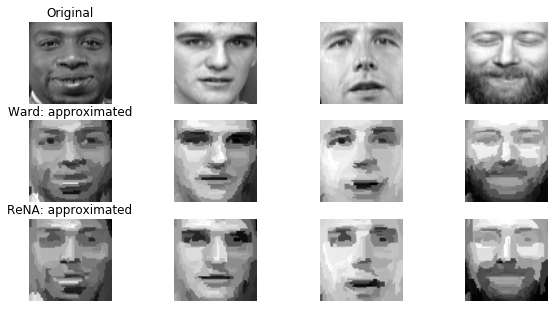

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axx = plt.subplots(3, 4, **{'figsize': (10, 5)})
plt.gray()

for i in range(4):
    axx[0, i].imshow(X[i + 30].reshape(n_x, n_y))
    axx[0, i].set_axis_off()
    axx[0, 0].set_title('Original')
    axx[1, i].imshow(X_approx_ward[i + 30].reshape(n_x, n_y))
    axx[1, i].set_axis_off()
    axx[1, 0].set_title('Ward: approximated')
    axx[2, i].imshow(X_approx_rena[i + 30].reshape(n_x, n_y))
    axx[2, i].set_axis_off()
    axx[2, 0].set_title('ReNA: approximated')

In [6]:
# saving results
fig.savefig('figures/faces.png', bbox_to_inches='tight')